# Chapter 2: Classifying with Real-world Examples

**Classification** is a form of machine learning where the system takes examples of two types of objects (or more) and uses these examples to learn rules that can be applied to classify new examples.

## The Iris dataset

Example: use the Iris dataset, a collection of morphological measurements of several Iris flowers which will be used to distinguish multiple species of the flowers. This dataset is available from the scikit-learn library. The attributes measured are:

- sepal length
- sepal width
- petal length
- petal width

We will use the term **features** to name the individual numerical measurements used to describe the data. Features can be directly measured or computed from intermediate data.

In this example we have four features; additionally, for each plant we also have the species. The problem to solve is: given these examples, if we see a new flower out in the field could we classify its species from its measurements? This is an example of **supervised learning**.

### Visualisation

Visualisation is always a good first step. With a small dataset it's easier - we can easily plot all two-dimensional projections on a single page. Visualisations are excellent at the initial exploratory phase of the analysis as they allow you to learn the general features of your problem as well as catch data collection issues early.

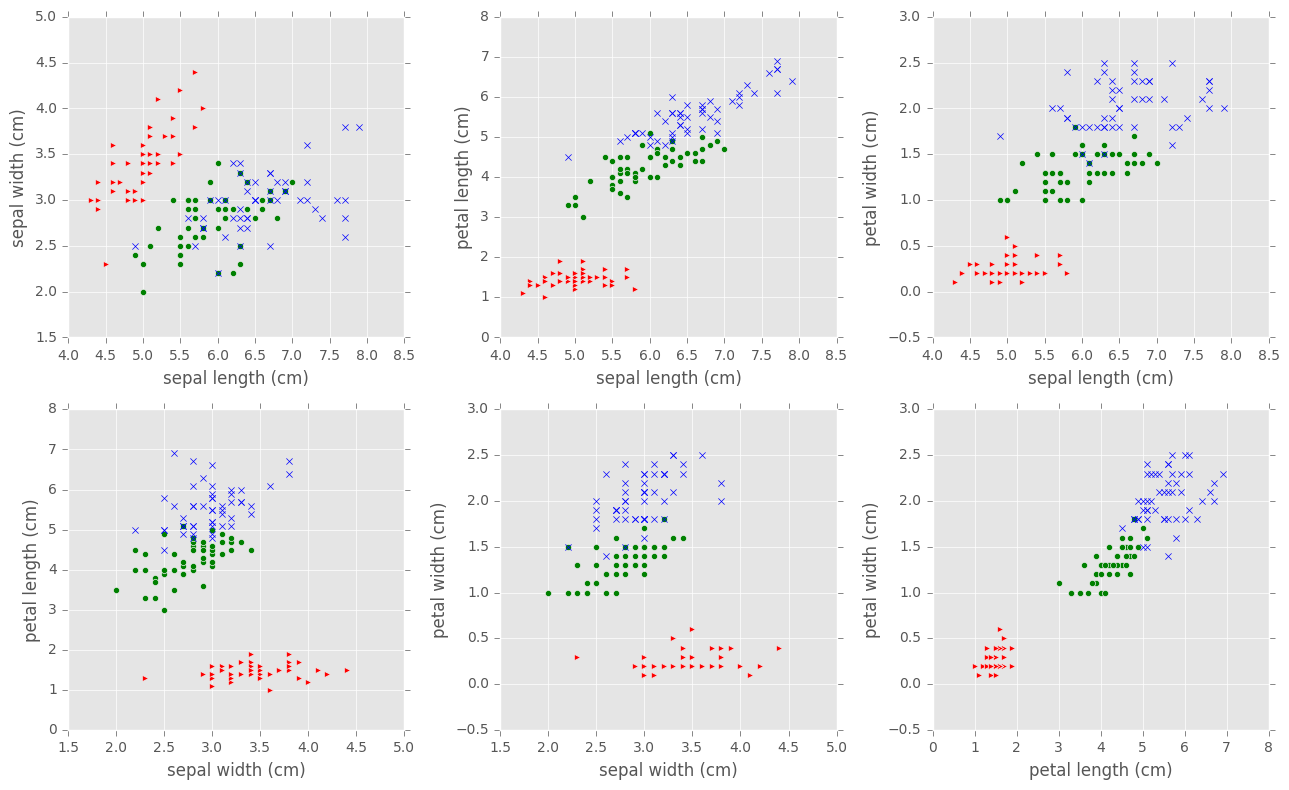

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from itertools import combinations, product
from __future__ import print_function

plt.style.use('ggplot')

# load_iris returns an object with several fields
data = load_iris()
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names

# Get all possible combinations of feature pairs
comb = list(combinations([0, 1, 2, 3], 2))

# Placement of figures
place = list(product([0, 1], [0, 1, 2]))

f, axarr = plt.subplots(2, 3, figsize=(13,8))
for ind, c in enumerate(comb):
    xind, yind = c
    xp, yp = place[ind]
    for t in range(3):
        if t == 0:
            c = 'r'
            marker = '>'
        elif t == 1:
            c = 'g'
            marker = 'o'
        elif t == 2:
            c = 'b'
            marker = 'x'
        axarr[xp, yp].scatter(features[target == t, xind],
                              features[target == t, yind],
                              marker=marker, c=c)
        axarr[xp, yp].set_xlabel(feature_names[xind])
        axarr[xp, yp].set_ylabel(feature_names[yind])
plt.tight_layout()
plt.show();

Each subplot in the plot above shows all points projected into two of the dimensions. The outlying group (red triangles) are the Iris Setosa plants, while Iris Versicolor plants are in the centre (green circles) and the Iris Virginica are plotted with blue `x` marks. Two large groups can clearly be seen, one is of Iris Setosa and the other is a mixture of Versicolor and Virginica.

### Building a first classification model

The goal is to separate the three types of flowers. Just by looking at the plots we can immediately make a few suggestions: for example, petal length seems to be able, on its own, to separate Iris Setosa from the other two species. Noting this we can build a simple model to identify Iris Setosa flowers:

In [14]:
# Replace numerical class indices by string names
labels = target_names[target]

# Extract the petal length (feature at position 2)
plength = features[:, 2]

# Build an array of Booleans
is_setosa = (labels == 'setosa')

# Find the maximum petal length of a setosa flower, and the minimum length
# of non-setosa flowers
max_setosa = plength[is_setosa].max()
min_nonsetosa = plength[~is_setosa].min()
print('Maximum of setosa: {0}.'.format(max_setosa))
print('Minimum of others: {0}.'.format(min_nonsetosa))

Maximum of setosa: 1.9.
Minimum of others: 3.0.


With this, our simple model is:
- if petal length < 2 cm, then it is an Iris Setosa flower;
- otherwise, it is either Iris Virginica or Iris Versicolor.

Here we actually *haven't done any machine learning* - we looked at the data and found a rule by ourselves. What we really want to do is to find this automatically. Note that just by looking at the data one cannot easily say what the appropriate rule for separating Virginica from Versicolor would be. We could try to look for the best possible separation, that is, the one which results in the fewest possible classification errors.

In [15]:
features = features[~is_setosa]
labels = labels[~is_setosa]

# Build a new target variable, is_virginica
is_virginica = (labels == 'virginica')

# Run a loop over all possible features to see which one results
# in better accuracy (i.e. fraction of examples that the model
# classifies correctly)
best_acc = -1.0
for fi in range(features.shape[1]):
    # Test all possible thresholds
    thresh = features[:, fi]
    for t in thresh:
        # Get the vector for feature fi
        feature_i = features[:, fi]
        # Apply the threshold
        pred = feature_i > t
        acc = (pred == is_virginica).mean()
        rev_acc = (pred == ~is_virginica).mean()
        if rev_acc > acc:
            reverse = True
            acc = rev_acc
        else:
            reverse = False
        
        if acc > best_acc:
            best_acc = acc
            best_fi = fi
            best_t = t
            best_reverse = reverse

We need to test two types of thresholds for each feature and value: a *greater than* threshold and the reverse comparison.

We compare the predictions with the actual labels: the trick of calculating the mean of the comparisons gives us the fraction of correct results, i.e. the accuracy.

At the end of the loop all the possible thresholds for all the possible features have been tested, and the variables `best_fi`, `best_t` and `best_reverse` hold our model. To classify a new, unknown object:

In [16]:
def is_virginica_test(example, fi, t, reverse):
    "Apply threshold model to a new example"
    test = example[fi] > t
    if reverse:
        test = not test
    return test

One way to gain intuition about how this is working is to visualise the **decision boundary**.

In [17]:
print("Best feature: {0} [{1}]".format(best_fi, feature_names[best_fi]))
print("Best threshold: {0}".format(best_t))
print("Best accuracy: {0}".format(best_acc))

Best feature: 3 [petal width (cm)]
Best threshold: 1.6
Best accuracy: 0.94


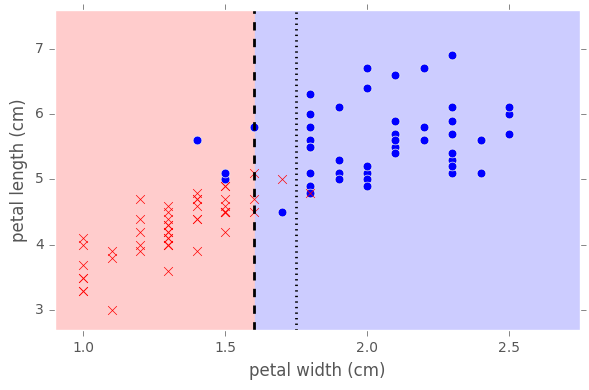

In [18]:
t = best_t
t2 = 1.75

# We'll plot the best feature vs the others
fx, fy = 3, 2

# Colours for the area shading
area1c = (1., .8, .8)
area2c = (.8, .8, 1.)

# Set axes limits
# Plot from 90% of smallest value to 110% of largest value
# (all feature values are positive, otherwise this would not work very well)
x0 = features[:, fx].min()*.9
x1 = features[:, fx].max()*1.1

y0 = features[:, fy].min()*.9
y1 = features[:, fy].max()*1.1

fig, ax = plt.subplots()
ax.fill_between([t, x1], [y0, y0], [y1, y1], color=area2c)
ax.fill_between([x0, t], [y0, y0], [y1, y1], color=area1c)
ax.plot([t, t], [y0, y1], 'k--', lw=2)
ax.plot([t2, t2], [y0, y1], 'k:', lw=2)
ax.scatter(features[is_virginica, fx],
           features[is_virginica, fy],
           c='b', marker='o', s=40)
ax.scatter(features[~is_virginica, fx],
           features[~is_virginica, fy],
           c='r', marker='x', s=40)
ax.set_ylim(y0, y1)
ax.set_xlim(x0, x1)
ax.set_xlabel(feature_names[fx])
ax.set_ylabel(feature_names[fy])
fig.tight_layout()

In the plot above, the additional threshold plotted (dotted line) results in the same accuracy as the one chosen by the above method; the method chooses the first threshold it finds. Any datapoint that falls in the red region will be classified as Iris Virginica, whereas any point that falls on the blue region will be classified as Iris Versicolor.

### Evaluation - holding out data and cross-validation

The simple model presented above achieves 94 per cent accuracy on the whole of the data. However, this evaluation is overly optimistic - we used the data to define what the threshold should be, then used the same data to evaluate the model (circular reasoning). What we really want is to estimate the ability of the model to generalise to new instances; for that we need to measure its performance in cases which the algorithm has not seen at training.

For this, break up the data into two groups: one to train the model (70 data points, selected at random), and the other to test it (the remaining 30 data points).

In [19]:
seedval = 123456
np.random.seed(seedval)
samp = np.random.permutation(100)

cut = 70

features_train = features[0:cut,]
features_test = features[cut:,]

labels_train = labels[0:cut]
labels_test = labels[cut:]

# Build a new target variable, is_virginica
is_virginica = (labels_train == 'virginica')

best_acc = -1.0
for fi in range(features_train.shape[1]):
    # Test all possible thresholds
    thresh = features_train[:, fi]
    for t in thresh:
        # Get the vector for feature fi
        feature_i = features_train[:, fi]
        # Apply the threshold
        pred = feature_i > t
        acc = (pred == is_virginica).mean()
        rev_acc = (pred == ~is_virginica).mean()
        if rev_acc > acc:
            reverse = True
            acc = rev_acc
        else:
            reverse = False
        
        if acc > best_acc:
            best_acc = acc
            best_fi = fi
            best_t = t
            best_reverse = reverse

In [20]:
# Now use the test data to evaluate the model
predict = np.apply_along_axis(is_virginica_test, 1, features_test, best_fi, best_t, best_reverse)

is_virginica = (labels_test == 'virginica')
test_acc = (predict == is_virginica).mean()
rev_acc = (predict == ~is_virginica).mean()
if rev_acc > test_acc:
    test_acc = rev_acc
    
print("Training accuracy: {0}".format(best_acc))
print("Testing accuracy: {0}".format(test_acc))

Training accuracy: 0.957142857143
Testing accuracy: 0.833333333333
